# Identifying Ideal Parameters for A-DBSCAN to Accurately Compare Against LISA

**Hypothesis**
In order to make useful and thoughtful comparisons between a clustering method like A-DBSCAN and LISA (or any other spatial statistical hotspot analysis on polygonal units), the parameters used to define cluster neighordhoods in the clustering algorithm are of the utmost importance. Here, we seek to identify ways in which these parameters can be fine tuned to correspond to the polygonal units used in the polygonal hotspot analysis.

For the $\epsilon$ (eps) parameter, I propose two different ways in which we can identify a suitable value.

1. Find the maximum height or width of the CTU units and use that value as $\epsilon$
2. Find the average height and/or width of the CTU units and use that value as $\epsilon$

For the minimum samples parameter, I propose two different ways in which we can identify a suitable value.

1. Find the average density of accidents per CTU, across all CTUs
2. Find the average density of accidents per CTU, across only CTUs labeled by LISA as being HH
3. Find the average density of accidents per CTU, across only CTUs labeled by LISA as being HH or HL

After finding the average density, the minimum samples parameter can then be derived through the use of the following equeation (with a known value for $\epsilon$):

$$Density = \frac{MinSamples}{\pi \times \epsilon^2}$$

$$MinSamples = Density \times (\pi \times \epsilon^2)$$

In [1]:
# Imports
import warnings

warnings.filterwarnings("ignore")

from math import pi

import contextily as ctx
import geopandas as gpd
import numpy as np
import pandas as pd
from esda import Moran_Local
from esda.adbscan import ADBSCAN, get_cluster_boundary
from matplotlib import pyplot as plt
from pysal.lib import weights
from shapely.geometry import Polygon

## Load Data

In [2]:
# Load GeoJSONs
incidents_gdf = gpd.read_file("../../data/core/INCIDENTS.geojson")
ctu_gdf = gpd.read_file("../../data/core/CTU.geojson")

In [3]:
# Convert Coordinate Systems to 26915 (meters)
incidents_gdf = incidents_gdf.to_crs(26915)
ctu_gdf = ctu_gdf.to_crs(26915)

## CTU Unit Measurements

In [4]:
# Compute Bounds of CTUs
ctu_bounds = ctu_gdf.bounds

ctu_bounds.head()

minx         miny        maxx         maxy
0  285341.090  5041770.711  295291.159  5051660.670
1  553925.051  4845541.211  563616.969  4855237.789
2  446706.620  4983335.589  449122.160  4985230.959
3  238669.859  5285402.119  248835.651  5295541.370
4  393233.217  5238673.629  432090.499  5271315.471

In [5]:
# Calculate Deltas
ctu_bounds["delta_x"] = ctu_bounds["maxx"] - ctu_bounds["minx"]
ctu_bounds["delta_y"] = ctu_bounds["maxy"] - ctu_bounds["miny"]

ctu_bounds.head()

minx         miny        maxx         maxy    delta_x    delta_y
0  285341.090  5041770.711  295291.159  5051660.670   9950.069   9889.959
1  553925.051  4845541.211  563616.969  4855237.789   9691.918   9696.578
2  446706.620  4983335.589  449122.160  4985230.959   2415.540   1895.370
3  238669.859  5285402.119  248835.651  5295541.370  10165.792  10139.251
4  393233.217  5238673.629  432090.499  5271315.471  38857.282  32641.842

In [6]:
# Calculate Average Deltas
print(f'Average Delta (X): {ctu_bounds["delta_x"].mean()}, Standard Deviation: {ctu_bounds["delta_x"].std()}, Median: {ctu_bounds["delta_x"].median()}')
print(f'Average Delta (Y): {ctu_bounds["delta_y"].mean()}, Standard Deviation: {ctu_bounds["delta_y"].std()}, Median: {ctu_bounds["delta_y"].median()}')

# Together
combined_deltas = np.concatenate((ctu_bounds["delta_x"].values, ctu_bounds["delta_y"].values))
print(f'Average Delta (X+Y): {combined_deltas.mean()}, Standard Deviation: {combined_deltas.std()}, Median: {np.median(combined_deltas)}')

Average Delta (X): 8397.009968986877, Standard Deviation: 5670.361265749584, Median: 9782.738499999163
Average Delta (Y): 8450.395746756525, Standard Deviation: 6177.79514924179, Median: 9768.20949999988
Average Delta (X+Y): 8423.7028578717, Standard Deviation: 5928.488368161825, Median: 9776.16465000005


In [7]:
# Calculate Maximum Deltas
print(f'Maximum Delta (X): {ctu_bounds["delta_x"].max()}')
print(f'Maximum Delta (Y): {ctu_bounds["delta_y"].max()}')
print(f'Maximum Delta (X+Y): {combined_deltas.max()}')

Maximum Delta (X): 87723.08100000059
Maximum Delta (Y): 91748.80099999998
Maximum Delta (X+Y): 91748.80099999998


### What about Outliers?

Given what we see below, there are certainly outliers, which is to be expected. However, given what we see in the metrics above, it seems like the mean values are adequate to test, while the maximum values will not be appropriate to use.

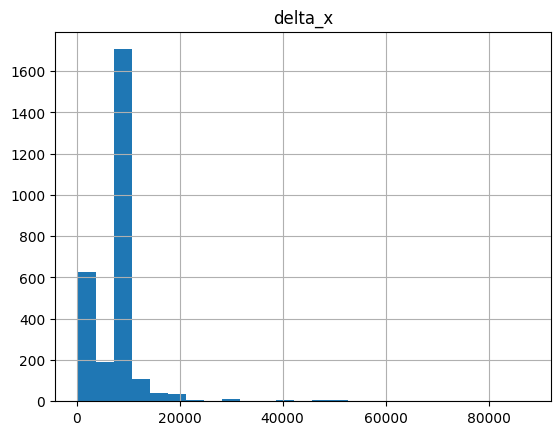

In [8]:
# Histograms of Delta X
ctu_bounds.hist(column="delta_x", bins=25);

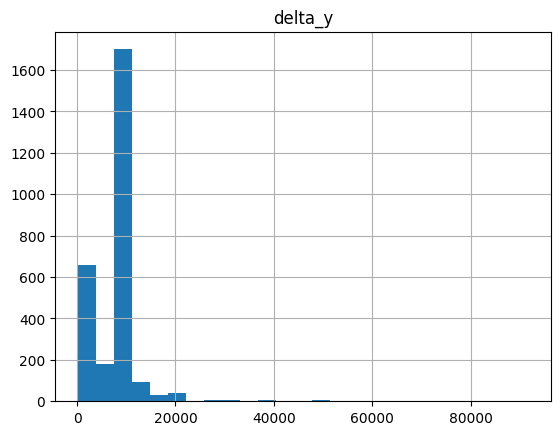

In [9]:
# Histograms of Delta Y
ctu_bounds.hist(column="delta_y", bins=25);

## Calculating Density

Now that we have some insights into what we may want to use for $\epsilon$ let's take a look at how we can use that to find the minimum samples parameter. To get started, we first need to look at the density of accidents across CTUs.

In [10]:
# Calculate Average Density per CTU (Accidents per Km^2)
((ctu_gdf["total_incident_count"] / ctu_gdf["geometry"].area).mean()) * 1000000

0.21322609958008484

In [11]:
# Calculate Average Density per CTU of HH CTUs (Accidents per Km^2)
((ctu_gdf.loc[ctu_gdf["lmi_label"] == "HH"]["total_incident_count"] / ctu_gdf.loc[ctu_gdf["lmi_label"] == "HH"]["geometry"].area).mean()) * 1000000

0.4828138155080134

In [12]:
# Calculate Average Density per CTU of HH & HL CTUs (Accidents per Km^2)
((ctu_gdf.loc[(ctu_gdf["lmi_label"] == "HH") | (ctu_gdf["lmi_label"] == "HL")]["total_incident_count"] / ctu_gdf.loc[(ctu_gdf["lmi_label"] == "HH") | (ctu_gdf["lmi_label"] == "HL")]["geometry"].area).mean()) * 1000000

0.5013600828333755

### Finding the Minimum Samples Parameters

Now that we have some density values to shoot for, let's use the $\epsilon$ values we found earlier (we will use the mean and median for the combined X & Y deltas) to find the minimum sample parameters.

In [13]:
# Eps = Mean, Density = All CTUs
eps = 8423.7028578717 / 1000
density = 0.21322609958008484

print(int(density * (pi * (eps)**2)))

47


In [14]:
# Eps = Mean, Density = HH CTUs
eps = 8423.7028578717 / 1000
density = 0.4828138155080134

print(int(density * (pi * (eps)**2)))

107


In [15]:
# Eps = Mean, Density = HH/HL CTUs
eps = 8423.7028578717 / 1000
density = 0.5013600828333755

print(int(density * (pi * (eps)**2)))

111


In [16]:
# Eps = Median, Density = All CTUs
eps = 9776.16465000005 / 1000
density = 0.21322609958008484

print(int(density * (pi * (eps)**2)))

64


In [17]:
# Eps = Median, Density = HH CTUs
eps = 9776.16465000005 / 1000
density = 0.4828138155080134

print(int(density * (pi * (eps)**2)))

144


In [18]:
# Eps = Median, Density = HH/HL CTUs
eps = 9776.16465000005 / 1000
density = 0.5013600828333755

print(int(density * (pi * (eps)**2)))

150


## Running A-DBSCAN

Now that we have come up with some parameters, let's test them out.

**Parameters**
1. $\epsilon$ = 8424 meters, Minimum Samples = 47 accidents (Average eps, All CTUs)
2. $\epsilon$ = 8424 meters, Minimum Samples = 107 accidents (Average eps, HH CTUs)
3. $\epsilon$ = 8424 meters, Minimum Samples = 111 accidents (Average eps, HH/HL CTUs)
4. $\epsilon$ = 9776 meters, Minimum Samples = 64 accidents (Median eps, All CTUs)
5. $\epsilon$ = 9776 meters, Minimum Samples = 144 accidents (Median eps, HH CTUs)
6. $\epsilon$ = 9776 meters, Minimum Samples = 150 accidents (Median eps, HH/HL CTUs)

In [19]:
# Get XY Coordinates
incidents_gdf["X"] = incidents_gdf.geometry.x
incidents_gdf["Y"] = incidents_gdf.geometry.y

incidents_gdf = incidents_gdf.drop(["x", "y"], axis=1)

incidents_gdf.head()

icr incident_type       incident_date            district  \
0  20601015        Injury 2020-03-04 07:35:00      2600 St. Cloud   
1  17901947        Injury 2017-09-09 18:39:00  2900 Detroit Lakes   
2  19901575        Injury 2019-07-28 13:28:00  2900 Detroit Lakes   
3  20902058        Injury 2020-12-07 16:30:00  2900 Detroit Lakes   
4  17900227        Injury 2017-01-21 10:58:00  2900 Detroit Lakes   

                                location_description road_condition  \
0  Highway 4 at County Road 28, Danielson Twp, Me...            Dry   
1  Eastbound Hwy 10 between Bluffton and Wadena, ...            Dry   
2  10 Highway / 77 County Road, Bluffton, Otter T...            Wet   
3  Westbound Hwy 10 MP87, BLUFFTON TWP, Otter Tai...            Dry   
4  East bound Hwy 10 west of Bluffton, Bluffton T...            Wet   

   vehicles_involved  city_id                        geometry              X  \
0                  2        2  POINT (366373.682 4988466.207)  366373.681889   
1                  1        3  POINT (328496.996 5148365.954)  328496.995648   
2                  1        3  POINT (328437.848 5148484.537)  328437.848091   
3                  1        3  POINT (327648.687 5148486.120)  327648.686590   
4                  3        3  POINT (327648.687 5148486.120)  327648.686590   

              Y  
0  4.988466e+06  
1  5.148366e+06  
2  5.148485e+06  
3  5.148486e+06  
4  5.148486e+06

In [20]:
# Function to run A-DBSCAN & Plot
def run_adbscan(df, eps, min_samples):
    # Create Model
    adbs = ADBSCAN(
        eps, min_samples, pct_exact=0.5, reps=50, keep_solus=True
    )
    
    # Fit Model
    adbs.fit(df)
    
    # Get Footprints
    adbs_polys = get_cluster_boundary(
        adbs.votes["lbls"], df, crs=df.crs
    )
    
    adbs_footprints = gpd.GeoDataFrame({"geometry": adbs_polys})
    
    # Mapping A-DBSCAN Results
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    ctu_gdf.to_crs(epsg=3857).plot(
        ax=ax,
        alpha=0
    )

    adbs_footprints.to_crs(epsg=3857).plot(
        ax=ax,
        alpha=0.75,
    )

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

    ax.axis("off")
    plt.show()
    
    return adbs_footprints

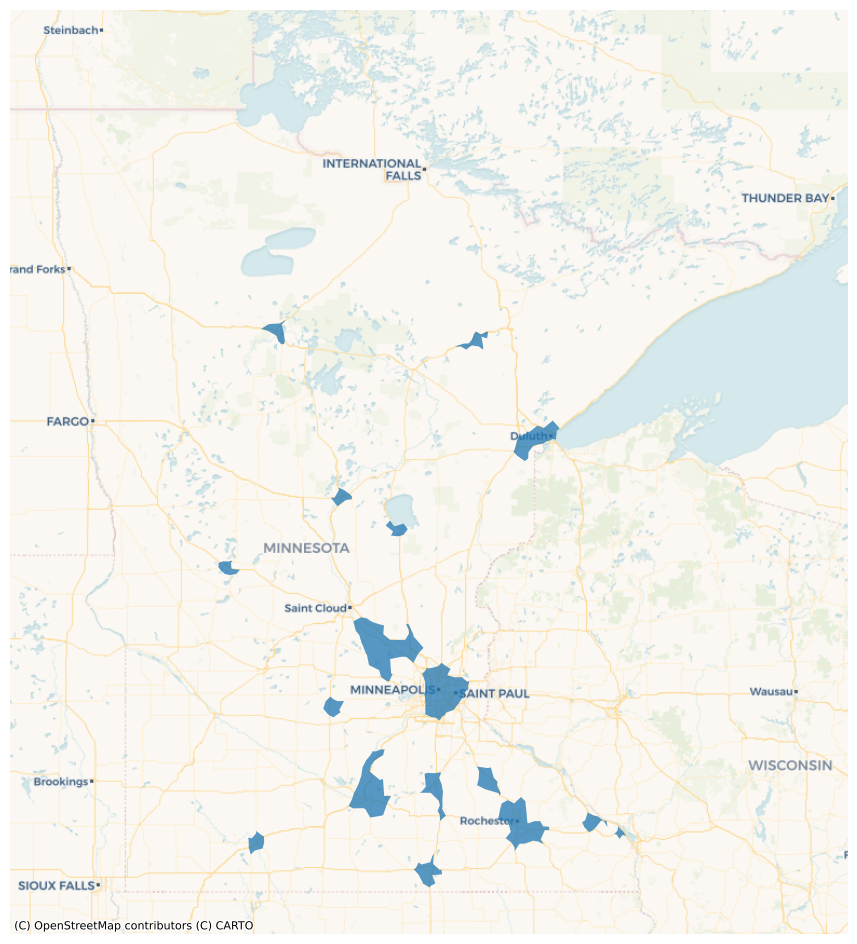

In [22]:
# Parameter Set 1
adbs_p1 = run_adbscan(incidents_gdf, 8424, 47)

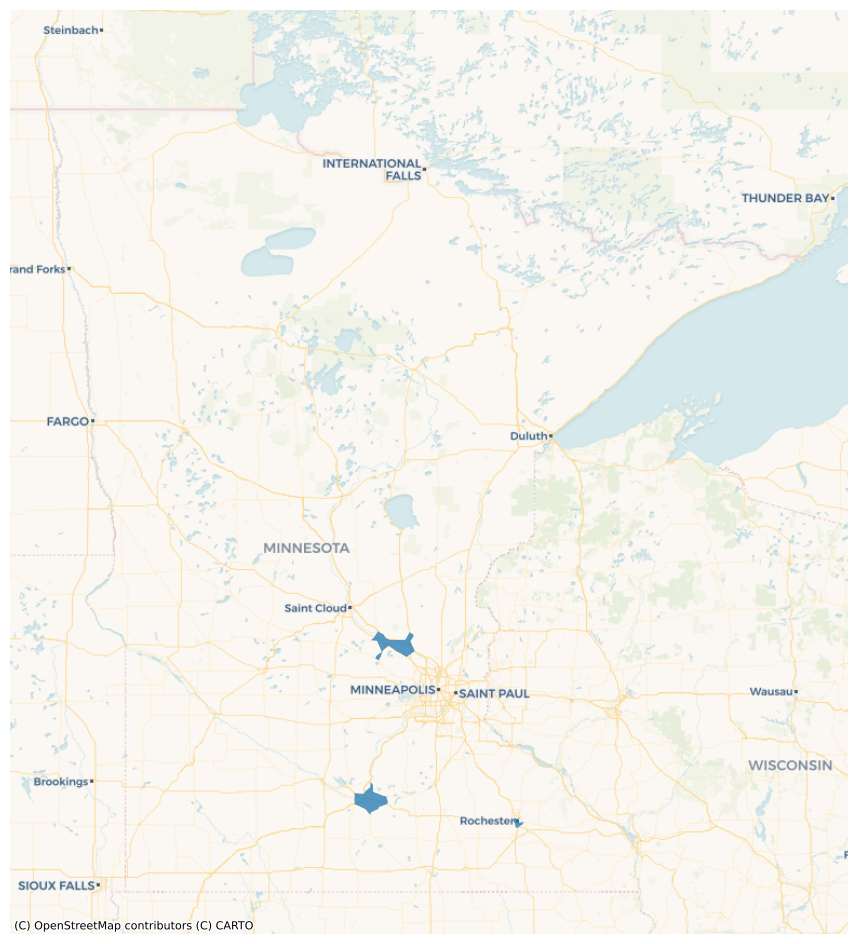

In [23]:
# Parameter Set 2
adbs_p2 = run_adbscan(incidents_gdf, 8424, 107)

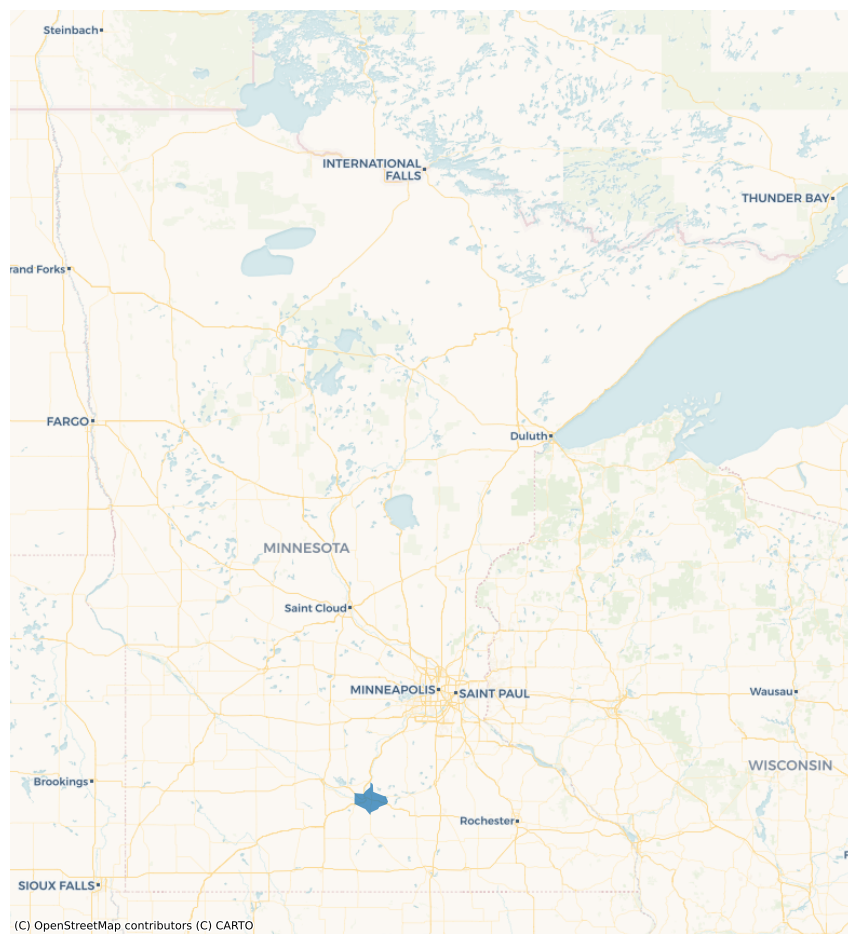

In [24]:
# Parameter Set 3
adbs_p3 = run_adbscan(incidents_gdf, 8424, 111)

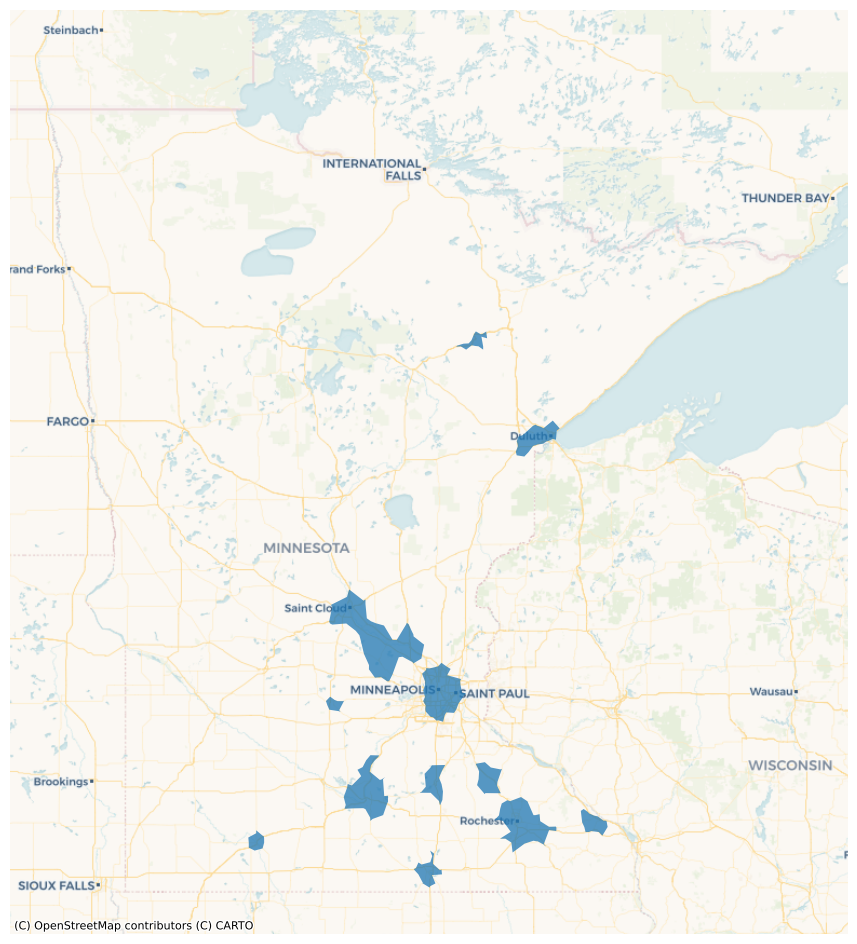

In [25]:
# Parameter Set 4
adbs_p4 = run_adbscan(incidents_gdf, 9776, 64)

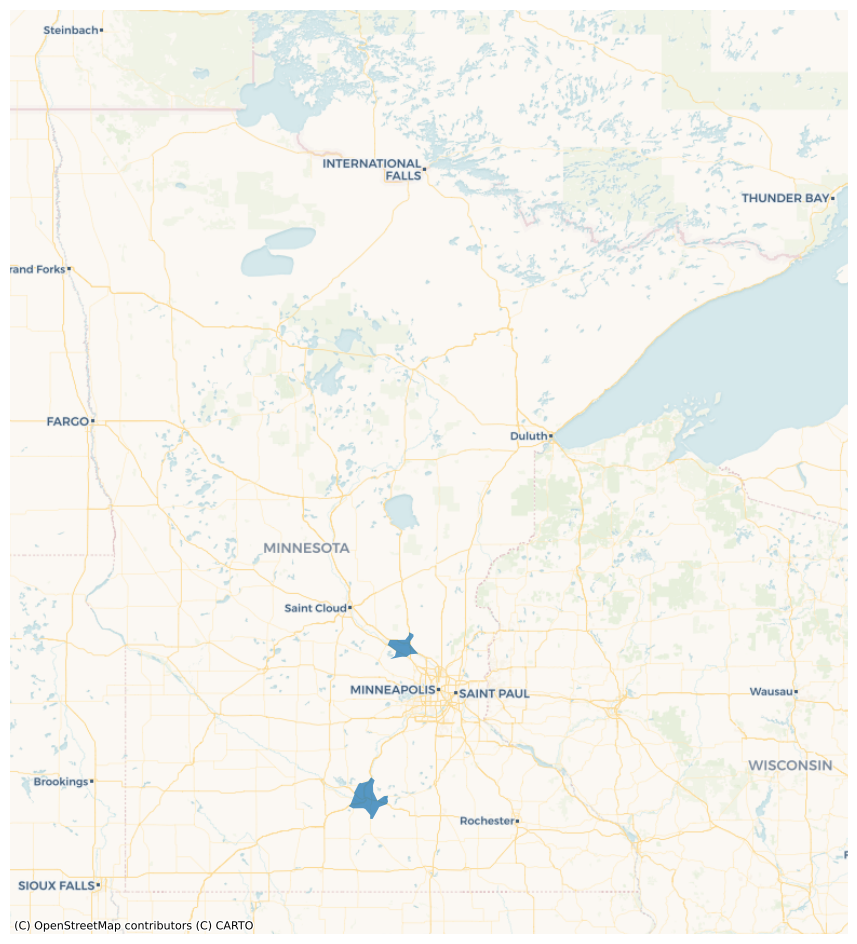

In [26]:
# Parameter Set 5
adbs_p5 = run_adbscan(incidents_gdf, 9776, 144)

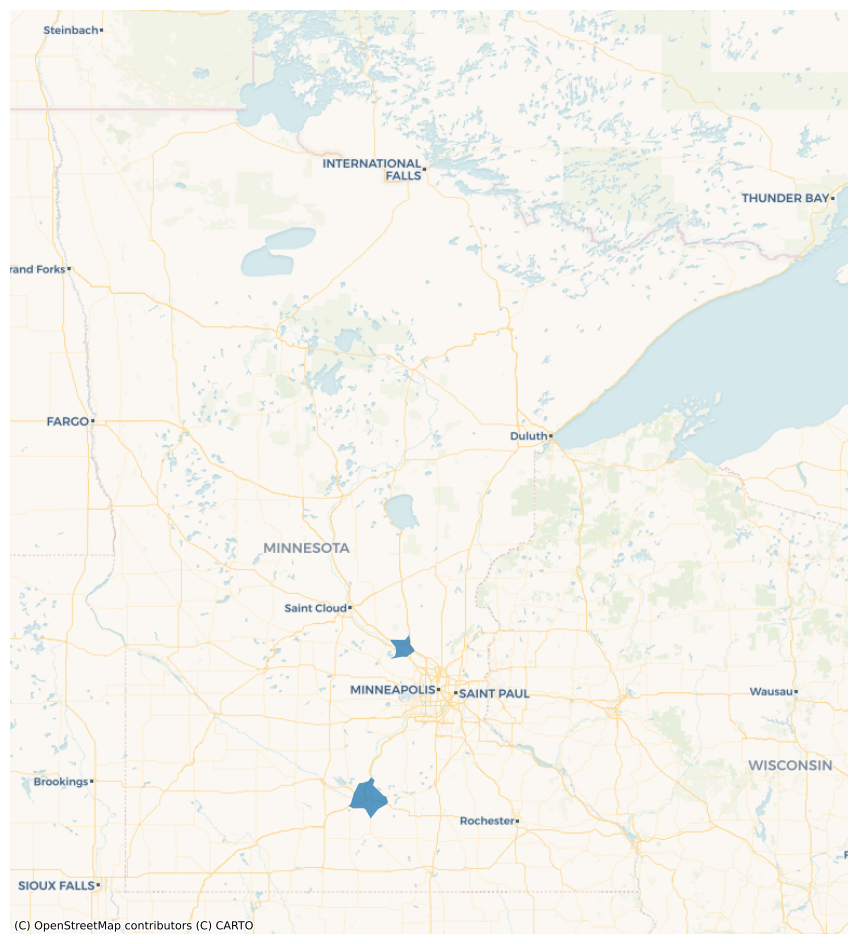

In [27]:
# Parameter Set 6
adbs_p6 = run_adbscan(incidents_gdf, 9776, 150)

## Comparison

Clearly, we see above that using the density calculated by use all CTUs (not just hotspots) provides the results that most closely resemble that of LISA. It's also important to note that the clusters only intend to resemble the LISA HH CTUs, since HL would likely not get picked up (they are outliers for a reason, after all).

LISA (standardized by road length) shows about 11 clusters (Virginia, Grand Rapids, Duluth, Mille Lacs, Saint Cloud/Elk River, Mankato/Le Sueur, Faribault, Albert Lea, Cannon Falls, Rochester, Winona).

Parameter set 1 shows about 8 clusters (Virginia, Duluth, Saint Cloud/Elk River, Twin Cities, Mankato/Le Sueur, Faribault, Albert Lea, Rochester).

Parameter set 4 shows about 10 clusters (Virginia, Duluth, Saint Cloud/Elk River, Twin Cities, Mankato/Le Sueur, Faribault, Albert Lea, Rochester, Winona, Cannon Falls).

Parameter set 4 appears to most closely align with the LISA results. It is important to note that LISA could look drastically different if the standardization was removed or changed to something else (like population, for example).

Below, LISA is performed on the raw accident counts without any standardization and the results do look different. There are about 12 main clusters (the same 11 as the original, with Twin Cities and Hutchinson added, and Cannon Falls and Rochester merged).

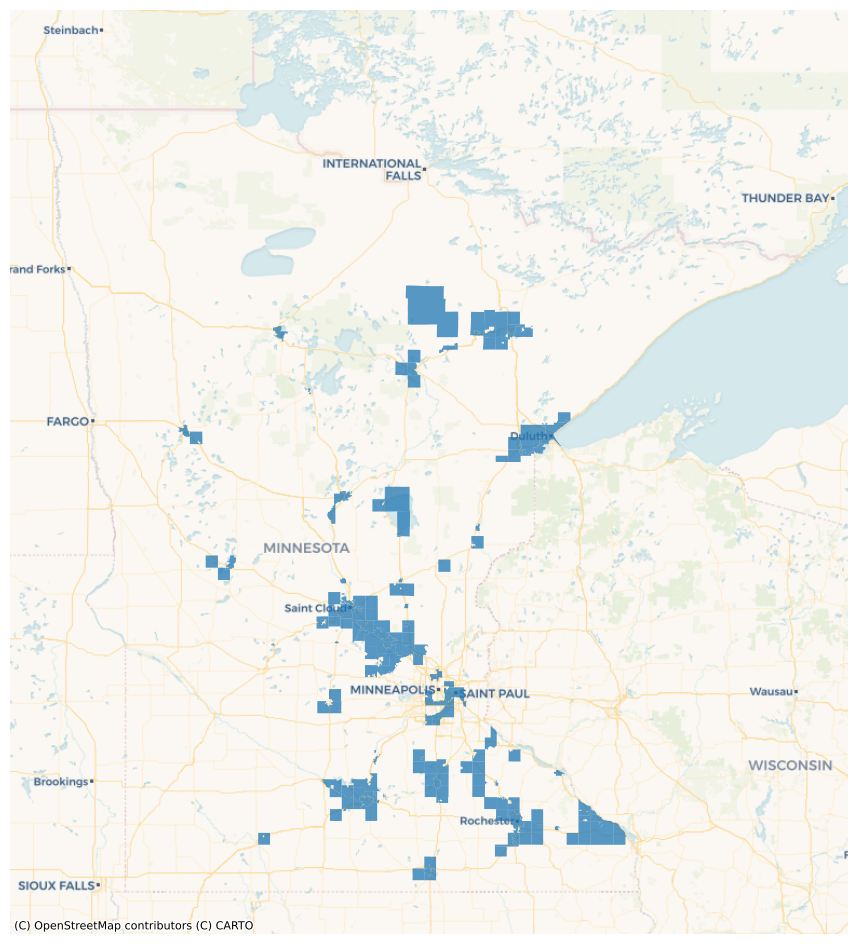

In [29]:
# LISA without Standardization
lisa_no_std = ctu_gdf.copy()

data = lisa_no_std["total_incident_count"].values

w = weights.Queen.from_dataframe(lisa_no_std)

moran_loc = Moran_Local(data, w)

lisa_no_std["lmi_i"] = moran_loc.Is
lisa_no_std["lmi_p"] = moran_loc.p_sim
lisa_no_std["lmi_sig"] = 1 * (moran_loc.p_sim < 0.05)
lisa_no_std["lmi_q"] = moran_loc.q

labels = {
    0: "NS",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}

lisa_no_std["lmi_label"] = pd.Series(
    moran_loc.q * (1 * (moran_loc.p_sim < 0.05)), index=lisa_no_std.index
).map(labels)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

hotspots_lisa_no_std = lisa_no_std.loc[(lisa_no_std["lmi_label"] == "HH")]

hotspots_lisa_no_std.plot(
    ax=ax,
    alpha=0.75
)

ctu_gdf.plot(
    ax=ax,
    alpha=0
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

### Quantitative Validation

#### Fishnet Creation

In [30]:
# Find Bounds
xmin, ymin, xmax, ymax = ctu_gdf.total_bounds

print(xmin, ymin, xmax, ymax)

-10824606.353575652 5388302.941234957 -9962177.457852405 6340228.568817256


In [31]:
# Settings
grid_size = 1609.34 * 5 # meters -> ~5 miles
rows = int(np.ceil((ymax - ymin) /  grid_size))
cols = int(np.ceil((xmax - xmin) / grid_size))

left = xmin
right = xmin + grid_size
top = ymax
bottom = ymax - grid_size

print(rows, cols)

119 108


In [32]:
# Create Fishnet
polygons = []
for i in range(cols):
    Ytop = top
    Ybottom = bottom
    for j in range(rows):
        polygons.append(Polygon([(left, Ytop), (right, Ytop), (right, Ybottom), (left, Ybottom)])) 
        Ytop -= grid_size
        Ybottom -= grid_size
    left += grid_size
    right += grid_size
    
grid = gpd.GeoDataFrame({"geometry":polygons}, crs=3857)

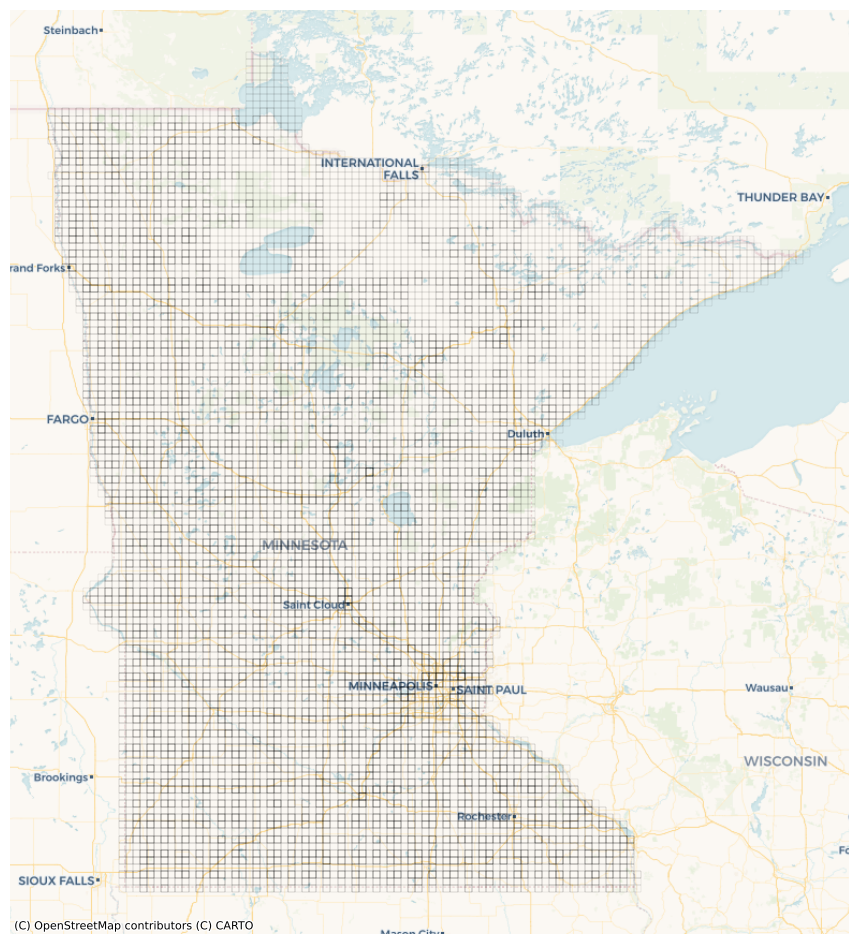

In [33]:
# Filter out Grid Cells
grid_ctu_sjoin = gpd.sjoin(grid, ctu_gdf)

grid = grid.loc[grid_ctu_sjoin.index]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

grid.boundary.plot(
    ax=ax,
    alpha=0.5,
    edgecolor="black",
    linewidth=0.1,
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()

In [34]:
# Reset Index
grid.reset_index(inplace=True, drop=True)
grid.reset_index(inplace=True)

grid = grid.rename(columns={grid.columns[0]: "grid_id"})

grid.head()

grid_id                                           geometry
0        0  POLYGON ((-10824606.354 6275854.969, -10816559...
1        1  POLYGON ((-10824606.354 6267808.269, -10816559...
2        2  POLYGON ((-10824606.354 6259761.569, -10816559...
3        3  POLYGON ((-10816559.654 6275854.969, -10808512...
4        4  POLYGON ((-10816559.654 6267808.269, -10808512...

#### LISA (Standardized) to Grid

In [35]:
# Joining LISA to Grid
lisa_hotspots = ctu_gdf.loc[ctu_gdf.lmi_label == "HH"]
lisa_grid = gpd.sjoin(grid, lisa_hotspots)

In [36]:
# Aggregating
grid["LISA_Binary"] = 0

for i in list(lisa_grid.index):
    grid.at[i, "LISA_Binary"] = 1

#### LISA (Non-Standardized) to Grid

In [37]:
# Joining LISA to Grid
lisa_hotspots_no_std = lisa_no_std.loc[lisa_no_std.lmi_label == "HH"]
lisa_grid_no_std = gpd.sjoin(grid, lisa_hotspots_no_std)

In [38]:
# Aggregating
grid["LISA_No_Std_Binary"] = 0

for i in list(lisa_grid_no_std.index):
    grid.at[i, "LISA_No_Std_Binary"] = 1

#### A-DBSCAN to Grid

##### Parameter Set 1

In [39]:
# Joining A-DBSCAN to Grid
adbs_grid_p1 = gpd.sjoin(grid, adbs_p1)

In [40]:
# Aggregating
grid["ADBSCAN_P1_Binary"] = 0

for i in list(adbs_grid_p1.index):
    grid.at[i, "ADBSCAN_P1_Binary"] = 1

##### Parameter Set 4

In [41]:
# Joining A-DBSCAN to Grid
adbs_grid_p4 = gpd.sjoin(grid, adbs_p4)

In [42]:
# Aggregating
grid["ADBSCAN_P4_Binary"] = 0

for i in list(adbs_grid_p4.index):
    grid.at[i, "ADBSCAN_P4_Binary"] = 1

#### Fishnet Results

In [43]:
# Show Table
grid.head()

grid_id                                           geometry  LISA_Binary  \
0        0  POLYGON ((-10824606.354 6275854.969, -10816559...            0   
1        1  POLYGON ((-10824606.354 6267808.269, -10816559...            0   
2        2  POLYGON ((-10824606.354 6259761.569, -10816559...            0   
3        3  POLYGON ((-10816559.654 6275854.969, -10808512...            0   
4        4  POLYGON ((-10816559.654 6267808.269, -10808512...            0   

   LISA_No_Std_Binary  ADBSCAN_P1_Binary  ADBSCAN_P4_Binary  
0                   0                  0                  0  
1                   0                  0                  0  
2                   0                  0                  0  
3                   0                  0                  0  
4                   0                  0                  0

In [44]:
# Create Correlation Matrix
corr = grid[[c for c in grid.columns if c not in ["geometry", "grid_id"]]].copy().corr()

corr.style.background_gradient(cmap="coolwarm")

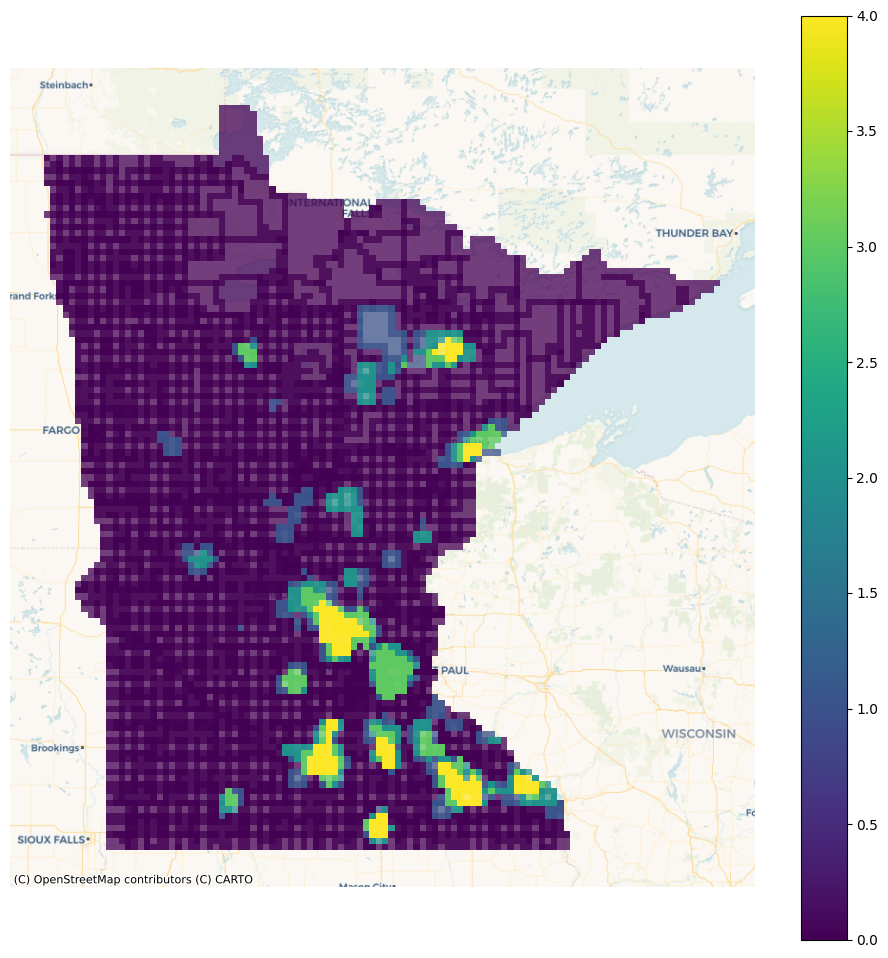

In [45]:
# Binary Agreement
grid["Binary_Total"] = grid["LISA_Binary"] + grid["LISA_No_Std_Binary"] + grid["ADBSCAN_P1_Binary"] + grid["ADBSCAN_P4_Binary"]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

grid.plot(
    ax=ax,
    alpha=0.75,
    column="Binary_Total",
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.axis("off")
plt.show()